## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS


from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
# Opening JSON file 

f =open("/content/drive/Othercomputers/My Laptop (2)/Upgrad DS/NLP/Ticket Classification/complaints-2021-05-14_08_16.json")# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign new column names
df.columns = [re.sub('^_', '', col) for col in df.columns]
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [8]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [9]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text

In [10]:
#Write your function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [11]:
 nltk.download('wordnet')
 nltk.download('punkt')
 nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [12]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(df['complaint_what_happened'])
df_clean["lemmatized_complaint"] =  df_clean['complaint_what_happened'].apply(lambda x: clean_data(x))
df_clean["lemmatized_complaint"] =  df_clean['lemmatized_complaint'].apply(lambda x: lemmatization(x))

In [ ]:
df_clean

,complaint_what_happened,lemmatized_complaint
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and wa told by the agent...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...
...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit card...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not underst...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr i ve had cha...


In [ ]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
  nn_words = []
  doc = nlp(text)
  for tok in doc:
      if(tok.tag_ == 'NN'):
          nn_words.append(tok.lemma_)
  nn_words_str = " ".join(nn_words)
  return nn_words_str



df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...


In [ ]:
df_clean.to_csv("/content/drive/Othercomputers/My Laptop (2)/Upgrad DS/NLP/Ticket Classification/df_clean.csv",index=False)

In [13]:
df_clean = pd.read_csv("/content/drive/Othercomputers/My Laptop (2)/Upgrad DS/NLP/Ticket Classification/df_clean.csv")
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,ticket offer ticket reward card information of...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [14]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   lemmatized_complaint     21072 non-null  object
 2   complaint_POS_removed    21070 non-null  object
dtypes: object(3)
memory usage: 494.0+ KB


In [15]:
df_clean["complaint_POS_removed"]=df_clean.complaint_POS_removed.astype(str)

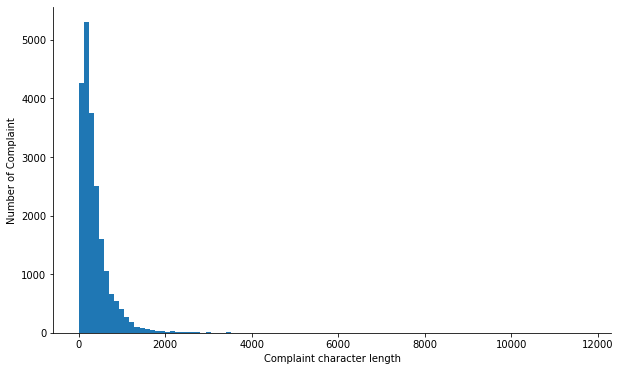

In [16]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens =  list([len(d) for d in df_clean["complaint_POS_removed"]])
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

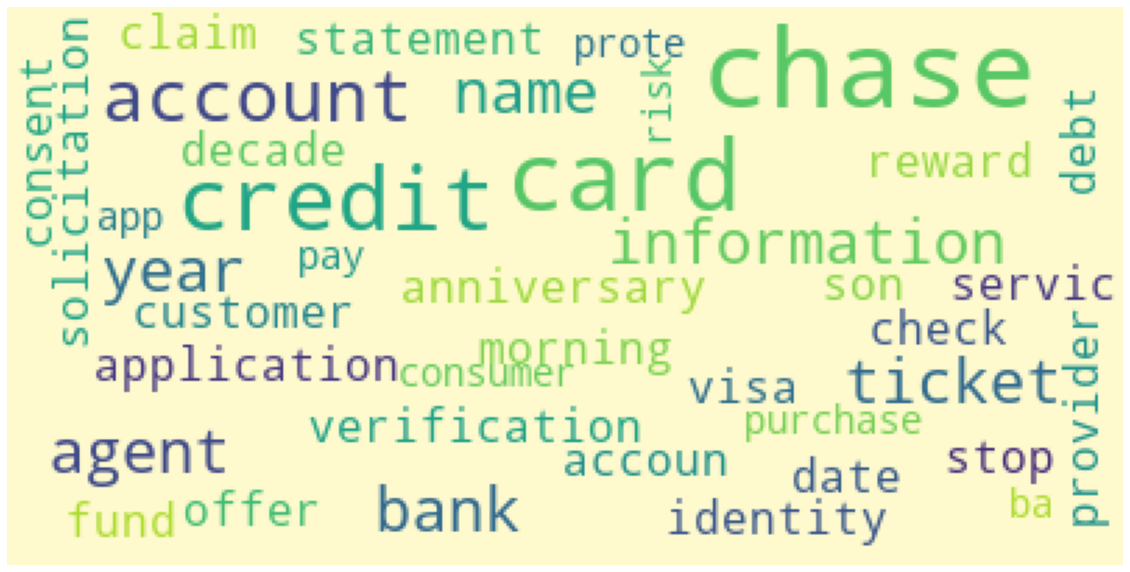

In [18]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords=set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='lemonchiffon',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [19]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['complaint_POS_removed'].values.astype('U'), 10)
df_uni = pd.DataFrame(common_words, columns = ['unigram' , 'count'])



In [21]:
#Print the top 10 words in the unigram frequency
df_uni.head(10)

,unigram,count
0,chase,65523
1,account,47426
2,credit,32807
3,card,30461
4,payment,21361
5,bank,18646
6,time,16307
7,day,13323
8,charge,12214
9,money,12004


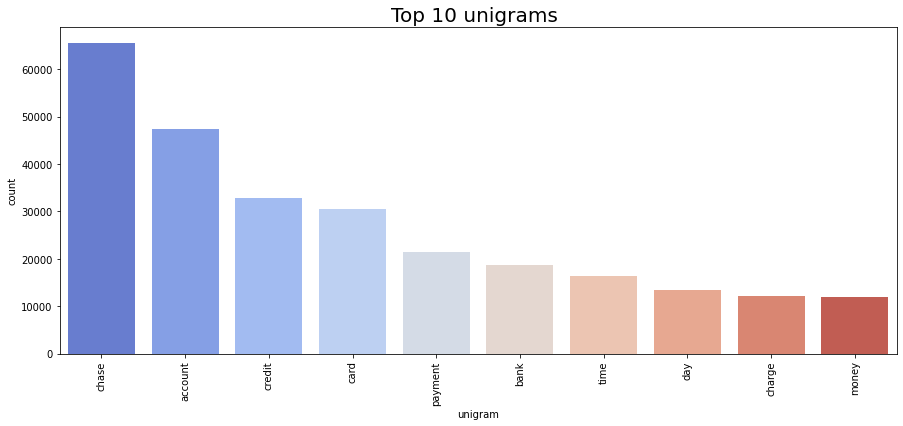

In [22]:
# Plot the top 10 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_uni.head(10), palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 10 unigrams ", fontsize=20)
plt.show()

In [23]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df_bi = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

In [24]:
#Print the top 10 words in the bigram frequency

df_bi.head(10)

,bigram,count
0,credit card,12928
1,account chase,4057
2,credit report,3893
3,chase credit,3835
4,checking account,3526
5,chase account,3277
6,chase bank,3209
7,customer service,3041
8,account account,2919
9,bank account,2323


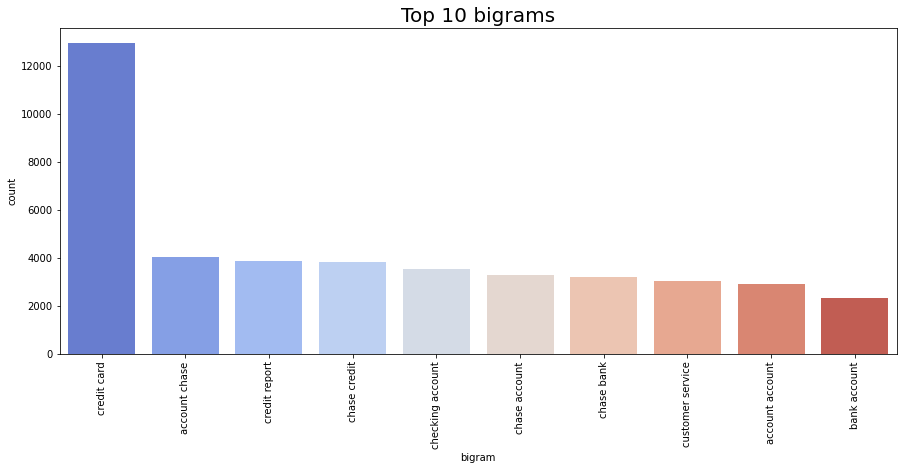

In [25]:
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bi.head(10), palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 10 bigrams", fontsize=20)
plt.show()

In [26]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df_tri = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

In [27]:
#Print the top 10 words in the trigram frequency
df_tri.head(10)

,trigram,count
0,chase credit card,2619
1,credit card account,1107
2,credit card company,1009
3,credit card chase,979
4,chase customer service,625
5,credit card credit,579
6,inquiry credit report,561
7,chase checking account,525
8,card credit card,467
9,account credit card,460


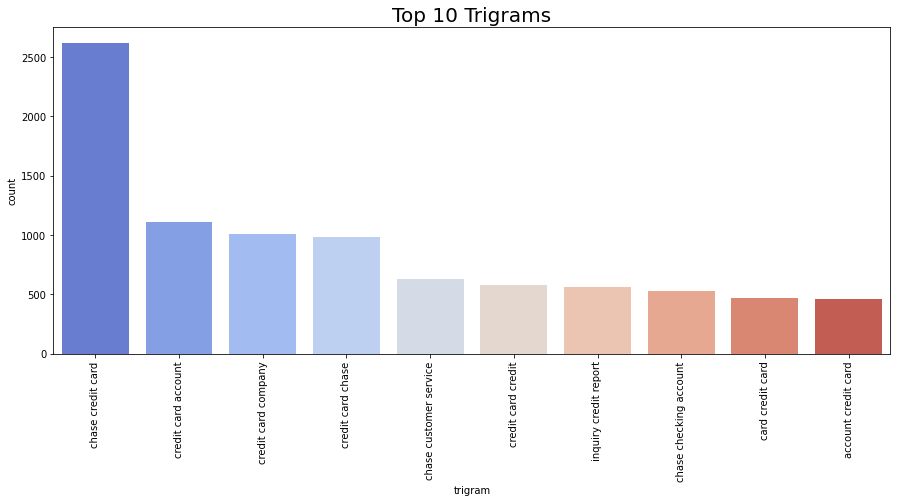

In [28]:
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_tri.head(10), palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 10 Trigrams", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [29]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...


In [30]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [31]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [32]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [33]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [34]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [35]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5#write the value you want to test out

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)#write your code here

In [36]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



5816

In [37]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,checking,deposit,branch,day,transaction,number,business,fee,claim
Topic 2,card,charge,chase,credit,dispute,purchase,transaction,fraud,service,merchant,time,fee,balance,company,customer
Topic 3,payment,balance,fee,month,statement,day,time,auto,chase,credit,date,year,account,error,car
Topic 4,credit,report,inquiry,card,account,score,bureau,debt,company,information,reporting,identity,application,theft,limit
Topic 5,loan,mortgage,chase,home,modification,property,year,letter,time,document,rate,foreclosure,house,sale,information


In [38]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)


array([4, 1, 1, ..., 3, 2, 2])

In [39]:
df_clean_backup = df_clean.copy()

In [40]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] =topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [41]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,4
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0


In [42]:
#Print the first 5 Complaint for each of the Topics
First5_comp=df_clean.groupby('Topic').head(5)
First5_comp.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
12,I opened an account with chase bank on XXXX an...,i opened an account with chase bank on and use...,account code bonus term everything account dep...,account code bonus term everything account dep...,0
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0
6,With out notice J.P. Morgan Chase restricted m...,with out notice j p morgan chase restricted my...,notice chase account debit card branch custome...,notice chase account debit card branch custome...,0
15,I opened the saving account for the {$25.00} b...,i opened the saving account for the bonus i wa...,saving account bonus bonus auto transfer trans...,saving account bonus bonus auto transfer trans...,0
10,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and,account chase auto,account chase auto,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1
16,"XXXX XXXX a sofa, love seat, table and chairs ...",a sofa love seat table and chair and wa never ...,sofa love seat table chair debit card bank cla...,sofa love seat table chair debit card bank cla...,1
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,1
14,My chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [43]:
#Create the dictionary of Topic names and Topics

Topic_names =  {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [44]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Theft/Dispute Reporting
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Others
2,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,Others
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Credit card or prepaid card
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Account Services
...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Others
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Others
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,Credit card or prepaid card
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,Mortgage/Loan


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [45]:
#Create the dictionary again of Topic names and Topics

Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
# Replace Topics with Topic Names

#df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Theft/Dispute Reporting
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Others
2,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,Others
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Credit card or prepaid card
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Account Services
...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Others
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Others
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,Credit card or prepaid card
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,Mortgage/Loan


In [47]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean.drop(['lemmatized_complaint', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [48]:
training_data

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I apprec...,Theft/Dispute Reporting
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Others
2,Chase Card was reported on XX/XX/2019. However...,Others
3,"On XX/XX/2018, while trying to book a XXXX XX...",Credit card or prepaid card
4,my grand son give me check for {$1600.00} i de...,Account Services
...,...,...
21067,After being a Chase Card customer for well ove...,Others
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Others
21069,I am not familiar with XXXX pay and did not un...,Credit card or prepaid card
21070,I have had flawless credit for 30 yrs. I've ha...,Mortgage/Loan


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [49]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [50]:
# Write your code here to build any 3 models and evaluate them using the required metrics


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (16857, 29725)
Shape of y_train: (16857,)
Shape of X_test: (4215, 29725)
Shape of y_test: (4215,)


In [51]:
def eval_model(y_test, y_pred, model_name):
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], zero_division=0))
    plt.figure(figsize=(10,6))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    return

In [65]:
# Logistic regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [66]:
f1_lr = f1_score(y_test, pred_lr, average="weighted")
f1_lr

0.9347753403318887

CLASSIFICATION REPORT for Logistic Regression

                             precision    recall  f1-score   support

      Bank Account services       0.93      0.95      0.94      1182
Credit card or prepaid card       0.95      0.89      0.92       549
                     Others       0.98      0.87      0.92       503
    Theft/Dispute Reporting       0.92      0.96      0.94      1251
              Mortgage/Loan       0.94      0.94      0.94       730

                   accuracy                           0.93      4215
                  macro avg       0.94      0.92      0.93      4215
               weighted avg       0.94      0.93      0.93      4215



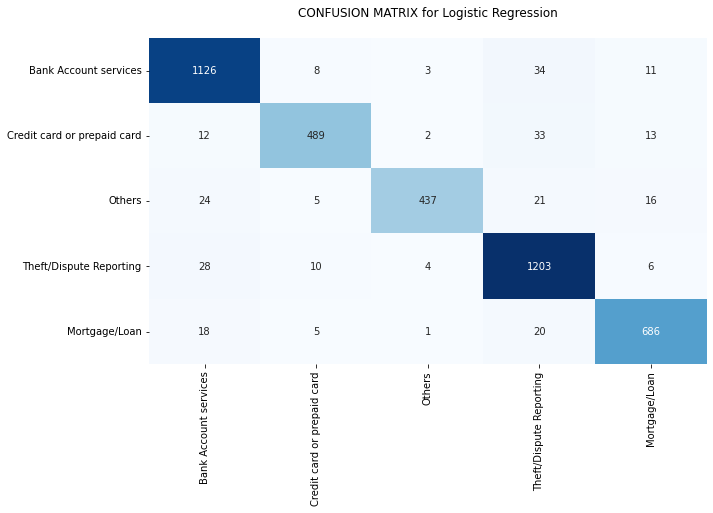

In [67]:
eval_model(y_test, pred_lr, "Logistic Regression")

In [69]:
#Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)


In [70]:
f1_dt = f1_score(y_test, pred_dt, average="weighted")
f1_dt

0.7975564958409871

CLASSIFICATION REPORT for Decision Tree

                             precision    recall  f1-score   support

      Bank Account services       0.82      0.83      0.82      1182
Credit card or prepaid card       0.75      0.74      0.74       549
                     Others       0.76      0.75      0.76       503
    Theft/Dispute Reporting       0.80      0.81      0.80      1251
              Mortgage/Loan       0.83      0.81      0.82       730

                   accuracy                           0.80      4215
                  macro avg       0.79      0.79      0.79      4215
               weighted avg       0.80      0.80      0.80      4215



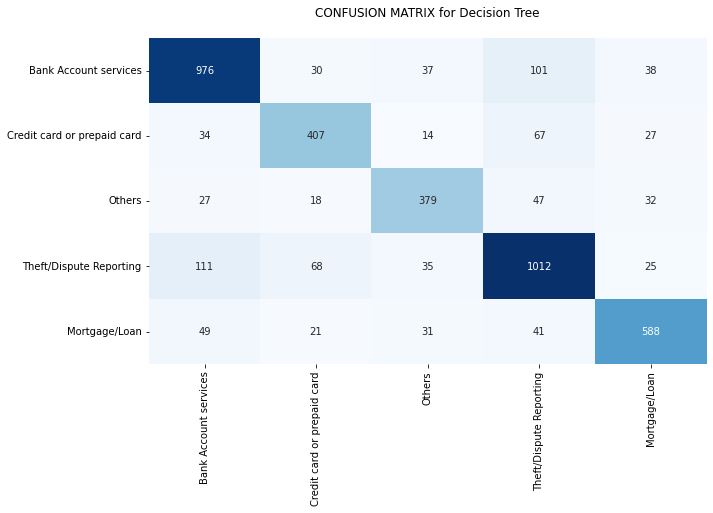

In [71]:
eval_model(y_test, pred_dt, "Decision Tree")

In [72]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = dt.predict(X_test)


In [73]:
f1_rf = f1_score(y_test, pred_rf, average="weighted")
f1_rf

0.7975564958409871

CLASSIFICATION REPORT for Random Forest

                             precision    recall  f1-score   support

      Bank Account services       0.82      0.83      0.82      1182
Credit card or prepaid card       0.75      0.74      0.74       549
                     Others       0.76      0.75      0.76       503
    Theft/Dispute Reporting       0.80      0.81      0.80      1251
              Mortgage/Loan       0.83      0.81      0.82       730

                   accuracy                           0.80      4215
                  macro avg       0.79      0.79      0.79      4215
               weighted avg       0.80      0.80      0.80      4215



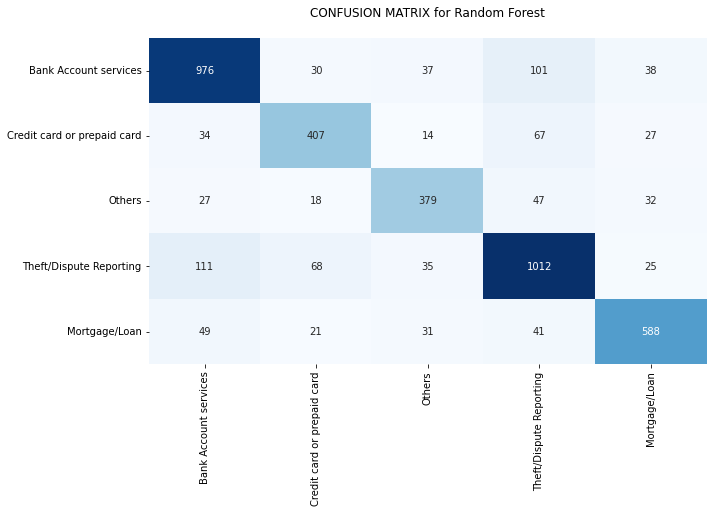

In [74]:
eval_model(y_test, pred_rf, "Random Forest")

In [75]:
# Model 4 naive Byes
nb =  MultinomialNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())


In [76]:
# Calculate F1 Score using weighted average method
f1_nb = f1_score(y_test, predicted, average="weighted")
f1_nb

0.6158420055013496

CLASSIFICATION REPORT for Naive Byes

                             precision    recall  f1-score   support

      Bank Account services       0.72      0.88      0.79      1182
Credit card or prepaid card       0.98      0.21      0.35       549
                     Others       0.82      0.03      0.05       503
    Theft/Dispute Reporting       0.56      0.91      0.69      1251
              Mortgage/Loan       0.86      0.72      0.78       730

                   accuracy                           0.67      4215
                  macro avg       0.79      0.55      0.53      4215
               weighted avg       0.74      0.67      0.62      4215



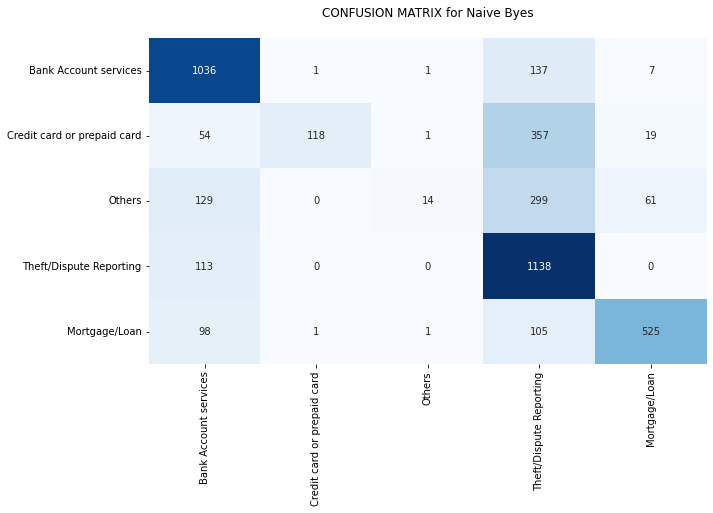

In [77]:
eval_model(y_test, predicted, "Naive Byes")

### Clearly logistic regression is performing better among all
### we can still do some parameter tuning and increase the model performance.
# Interfering Model

In [89]:
import random
random.sample(list(df["complaint_what_happened"]),5)
df_infer = pd.DataFrame({'complaints':random.sample(list(df["complaint_what_happened"]),3)})
df_infer

,complaints
0,I received a education loan from Chase Educati...
1,Keep in mind I was a victim of fraud and ident...
2,"On XX/XX/2020, I purchased a XXXX XXXX XXXX fr..."


In [92]:

def predict_lr(text):
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return predicted[0]
df_infer['tag'] = df_infer['complaints'].apply(lambda x: predict_lr([x]))
df_infer

,complaints,tag
0,I received a education loan from Chase Educati...,Theft/Dispute Reporting
1,Keep in mind I was a victim of fraud and ident...,Credit card or prepaid card
2,"On XX/XX/2020, I purchased a XXXX XXXX XXXX fr...",Others


In [97]:
pd.DataFrame({"Models":["Logistic Regression","Decision Tree","Random Forest","Naive Byes"],
    "F1_Score":[f1_lr*100,f1_dt*100,f1_rf*100,f1_nb*100]})

,Models,F1_Score
0,Logistic Regression,93.477534
1,Decision Tree,79.755650
2,Random Forest,79.755650
3,Naive Byes,61.584201
